# Classifying Mall Customers

## Introduction
Clustering's main task is to discover natural groups within an unlabeled dataset - this is an unsupervised ML task. And it's an important one, as it's used in a variety of scientific, engineering, and business fields. Among the most well-known applications of clustering are:  
* customer segmentation (for efficient marketing)
* image segmentation
* document clusterisation.
  
There are many clustering algorithms which can be divided into two main types: hierarchical and partitional.

* <u>Hierarchical</u> clustering algorithms cycle through the process of merging smaller clusters into larger clusters or dividing larger clusters into smaller clusters. In either case, it generates a dendogram, which is a hierarchy of clusters. Agglomerative clustering uses a bottom-up approach to merge clusters into larger ones, whereas divisive clustering uses a top-down approach to split into smaller ones. Typically, the greedy approach is used to determine which larger/smaller clusters to merge/divide. Some of the most commonly used metrics of similarity for numerical data are Euclidean distance, Manhattan distance, and cosine similarity. Metrics such as the Hamming distance are used for non-numerical data. </li>     

* <u>Partitional</u> clustering algorithms partition a dataset according to a set of criteria into multiple subsets, or clusters. Certain algorithms, like K-Means, require the number of clusters to be predetermined, while others do not (DBSCAN). Prior to executing an algorithm, defining the number of clusters frequently calls for specialized domain knowledge, which is difficult or impossible to obtain in many situations. As a result, numerous heuristics and streamlined methods were created to assist analysts lacking domain expertise in selecting the right number of clusters.</li>

There are numerous clustering methods, and no single one currently dominates the others. Choosing the best one is determined by the database, the application domain, and the client's requirements and expectations.
The partitional algorithms covered in this notebook include K-Means, DBSCAN, and Gaussian Mixture Models. All of this is done via a well-known Python module called Scikit-Learn.

<div>
<img src="https://cdn.denvermart.com/how_are_shopping_malls_doing.jpg" width="1000"/>
</div>


Image Source: [Denver Mart](https://www.denvermart.com/why-shopping-malls-are-doing-better-than-you-think/)

#### Our Reseach Problem

We are data scientists for a large supermarket with regional brands in shopping centers. We receive basic information about our consumers, such as age, gender, annual income, level of education, and city size, via membership cards. We are also provided a customer spending score, which is something you allocate to the consumer depending on characteristics you set, such as customer behavior and purchasing data. We want to know who our target customers are so that we can develop an accurate strategy for the mall's marketing team.

The main goal of this project is to learn the purpose of customer segmentation concepts, also known as market basket analysis, and to try to understand customers and divide them into different groups based on their preferences. Once the division is completed, this information can be given to the marketing team so that they can plan their strategy accordingly.

## Table of Contents
---
- [Introduction](#Introduction)
  - [Our Research Problem](#Our-Research-Problem)
- [Helper Functions](#Helper-Functions)
- [Reading Data](#Reading-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Distributions](#Distributions)
  - [Correlations](#Correlations)
- [Data Visualization](#Data-Visualization)
- [Model Preparation](#Model-Preparation)
- [Clustering](#Clustering)
  - [K-Means](#K-Means)
  - [DBSCAN](#DBSCAN)
  - [GMM](#GMM)
- [Dimensionality Reduction](#Dimensionality-Reduction)  
  - [PCA](#PCA)
- [Cluster Comparison and Analysis](#Cluster-Comparison-and-Analysis)
- [Discussion and Recommendations](#Discussion-and-Recommendations)

## Helper Functions

In [7]:
# Exploratory Data Analysis

# Visualize mean/median age data
def plot_age_bins(grp1, grp2, col1, col2, title1, title2):
  age_bins = range(15, 75, 5)

  # Plotting using displot
  fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

  # First histogram
  sns.histplot(grp1, bins=age_bins, kde=False, color=col1, ax=ax1, edgecolor="k", linewidth=2)
  ax1.set_xticks(age_bins)
  ax1.set_ylim(top=315)
  ax1.set_title(title1)
  ax1.set_ylabel('Count')
  ax1.text(45, 243, "TOTAL count: {}".format(grp1.count()))
  ax1.text(45, 230, "Mean age: {:.1f}".format(grp1.mean()))

  # Second histogram
  sns.histplot(grp2, bins=age_bins, kde=False, color=col2, ax=ax2, edgecolor="k", linewidth=2)
  ax2.set_xticks(age_bins)
  ax2.set_title(title2)
  ax2.set_ylabel('Count')
  ax2.text(45, 243, "TOTAL count: {}".format(grp2.count()))
  ax2.text(45, 230, "Mean age: {:.1f}".format(grp2.mean()))

  plt.show()

# Label data
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Visualize data percentages
def make_pie_chart(sizes, col1, col2, bbox_pos):
  fig0, ax1 = plt.subplots(figsize=(6,6))
  wedges, texts, autotexts = ax1.pie(sizes,
                                    autopct=lambda pct: labeler(pct, sizes),
                                    radius=1,
                                    colors=[col1,col2],
                                    startangle=90,
                                    textprops=dict(color="w"),
                                    wedgeprops=dict(width=0.7, edgecolor='w'))

  ax1.legend(wedges, ['male','female'],
            loc='center right',
            bbox_to_anchor=(0.7, 0, 0.5, 1))

  plt.text(0,0, 'TOTAL\n{}'.format(segmentation_df['Age'].count()),
          weight='bold', size=12, color='#52527a',
          ha='center', va='center')

  plt.setp(autotexts, size=12, weight='bold')
  ax1.axis('equal')  # Equal aspect ratio
  plt.show()

# Visualize mean/median income data
def plot_mean_income(grp1, grp2, col1, col2, title1, title2, xvar):
  my_bins = range(32000, 310000, 40000)

  # Plotting using displot
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 10))

  # First histogram
  sns.histplot(grp1, bins=my_bins, kde=False, color=col1, ax=ax1, edgecolor="k", linewidth=2)
  ax1.set_xticks(my_bins)
  ax1.set_ylim(0, 515)
  ax1.set_title(title1)
  ax1.set_ylabel('Count')
  ax1.text(120000, 505, "Mean income: ${:.1f}".format(grp1.mean()))
  ax1.text(120000, 485, "Median income: ${:.1f}".format(grp1.median()))
  ax1.text(120000, 465, "Std. deviation: ${:.1f}".format(grp1.std()))

  # Rotate x-axis ticks
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='right')

  # Second histogram
  sns.histplot(grp2, bins=my_bins, kde=False, color=col2, ax=ax2, edgecolor="k", linewidth=2)
  ax2.set_xticks(my_bins)
  ax2.set_ylim(0, 515)
  ax2.set_title(title2)
  ax2.set_ylabel('Count')
  ax2.text(120000, 505, "Mean income: ${:.1f}".format(grp2.mean()))
  ax2.text(120000, 485, "Median income: ${:.1f}".format(grp2.median()))
  ax2.text(120000, 465, "Std. deviation: ${:.1f}".format(grp2.std()))

  # Rotate x-axis ticks
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='right')

  # Boxplot
  sns.boxplot(x=xvar, y='Income', data=segmentation_df, ax=ax3)
  ax3.set_title('Boxplot of annual income')

  plt.show()

# Visualize income by age groups and categorical variable
def plot_income_by_age_groups(var, age_bins, label_mapping, col1, col2, plt_title):
  medians_by_age_group = segmentation_df.groupby([var,pd.cut(segmentation_df['Age'], age_bins)]).median()
  medians_by_age_group.index = medians_by_age_group.index.set_names([var, 'Age_group'])
  medians_by_age_group.reset_index(inplace=True)
  fig, ax = plt.subplots(figsize=(12, 5))

  sns.barplot(x='Age_group', y='Income', hue=var, data=medians_by_age_group,
              palette=[col1, col2],
              alpha=0.7, edgecolor='k',
              ax=ax)

  ax.set_title(plt_title)
  ax.set_xlabel('Age group')

  # Change legend labels using the mapping
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles, [label_mapping[int(label)] for label in labels])

  plt.show()

# Visualize correlations
def visual_corr(df, corr1, corr2, var1, var2, var3, xlab, ylab):
  # Plot using lmplot
  lm = sns.lmplot(data=df, x=var1, y=var2, hue=var3, aspect=2)

  # Change legend labels
  lm._legend.set_title(var3)
  lm._legend.set_bbox_to_anchor([1, 0.5])
  lm._legend.set_title(var3)
  lm._legend.texts[0].set_text(xlab)
  lm._legend.texts[1].set_text(ylab)

  figsize=(12,6)
  if var2 == 'Income':
    plt.text(20, 300000, 'Pearson: {:.2f}'.format(corr1), color='blue')
    plt.text(70, 300000, 'Pearson: {:.2f}'.format(corr2), color='orange')
  else:
    plt.text(20, 96, 'Pearson: {:.2f}'.format(corr1), color='blue')
    plt.text(70, 96, 'Pearson: {:.2f}'.format(corr2), color='orange')

  plt.show()


In [8]:
# Data Visualization

def plot_distribution_by_income(var, plt_title, leg_entries):
  plt.figure(figsize=(12, 6))
  ax = sns.histplot(data=segmentation_df, x='Income', hue=var, palette='deep')
  plt.title(plt_title, fontweight='bold')

  # Get the existing legend
  legend = ax.get_legend()

  # Update legend labels
  legend.set_title(var)
  for text, label in zip(legend.texts, leg_entries):
      text.set_text(label)

  plt.show()

def plot_age_vs_income_scatter(var, plt_title, leg_entries):
  plt.figure(figsize=(12, 6))
  ax = sns.scatterplot(data=segmentation_df, y='Income', x='Age', hue=var, palette='deep')
  sns.move_legend(ax, "upper right")
  plt.title(plt_title, fontweight='bold')

  # Get the existing legend
  legend = ax.get_legend()

  # Update legend labels
  legend.set_title(var)
  for text, label in zip(legend.texts, leg_entries):
      text.set_text(label)

  plt.show()

In [69]:
# Clustering

def visualize_knn_clusters(k, X_num):
  KM_clusters = KMeans(n_clusters=k, n_init=10, init='k-means++', random_state=123).fit(X_num) # initialise and fit K-Means model
  KM_clustered = X_num.copy()
  KM_clustered.loc[:,'Cluster'] = KM_clusters.labels_ # append labels to points

  fig1, (axes) = plt.subplots(1,2,figsize=(12,5))
  scat_1 = sns.scatterplot(data=KM_clustered, x='Income', y='Spending score',
                  hue='Cluster', ax=axes[0], palette='Set1', legend='full')

  sns.scatterplot(data=KM_clustered, x='Age', y='Spending score',
                  hue='Cluster', palette='Set1', ax=axes[1], legend='full')
  axes[0].scatter(KM_clusters.cluster_centers_[:,1],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="orange")
  axes[1].scatter(KM_clusters.cluster_centers_[:,0],KM_clusters.cluster_centers_[:,2], marker='s', s=40, c="orange")
  fig1.suptitle('K-Means Clustering for {} Clusters'.format(k))
  plt.show()

  return KM_clustered

def DBSCAN_heatmap_eps_min_samples(X_num):
  no_of_clusters = []
  sil_score = []

  for p in DBSCAN_params:
      DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_num)
      no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
      if len(np.unique(DBS_clustering.labels_)) > 1:
          sil_score.append(silhouette_score(X_num, DBS_clustering.labels_))
  tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
  tmp = tmp.reindex(range(len(sil_score)))
  tmp['Sil_score'] = sil_score

  pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

  fig, ax = plt.subplots(figsize=(18,6))
  sns.heatmap(pivot_1, vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
  plt.show()

def DBSCAN_cluster_size(X_num, DBS_clustering):
  DBSCAN_clustered = X_num.copy()
  DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

  # Generate Cluster Size
  DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
  DBSCAN_clust_sizes.columns = ["Size"]
  return DBSCAN_clust_sizes, DBSCAN_clustered

def plot_DBSCAN_clusters(X_num):
  fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

  sns.scatterplot(data=DBSCAN_clustered,
                  x='Income', y='Spending score',
                  hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

  sns.scatterplot(data=DBSCAN_clustered,
                  x='Age', y='Spending score',
                  hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

  axes[0].legend()
  axes[1].legend()

  plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
  plt.setp(axes[1].get_legend().get_texts(), fontsize='10')
  fig2.suptitle('DBSCAN Clustering for 2 Clusters')

  plt.show()

def plot_elbow_curve_gmm(X_num):
    meandist = []
    n_clusters = range(2,15)
    for n_cluster in n_clusters:
        gmm = GaussianMixture(n_components=n_cluster)
        gmm.fit(X_num)
        meandist.append(
          sum(
            np.min(
              cdist(X_num, gmm.means_, 'mahalanobis', VI=gmm.precisions_),
              axis=1
            )
            / X_num.shape[0]
          )
        )
    plt.plot(n_clusters,meandist,'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Mean Mahalanobis Distance')
    plt.title('GMM Clustering for n_cluster=2 to 15')
    plt.show()

def visualize_gmm_clusters(k, X_num):
  GM_clusters = GaussianMixture(n_components=k, n_init=10, random_state=123).fit_predict(X_num)
  GM_clustered = X_num.copy()
  GM_clustered.loc[:,'Cluster'] = GM_clusters # append labels to points

  fig1, (axes) = plt.subplots(1,2,figsize=(12,5))
  scat_1 = sns.scatterplot(data=GM_clustered, x='Income', y='Spending score',
                  hue='Cluster', ax=axes[0], palette='Set1', legend='full')

  sns.scatterplot(data=GM_clustered, x='Age', y='Spending score',
                  hue='Cluster', palette='Set1', ax=axes[1], legend='full')
  fig1.suptitle('Gaussian Mixture Clustering for {} Clusters'.format(k))
  plt.show()

  return GM_clusters, GM_clustered

def get_silhouette_score(X, k):
  model = KMeans(k, n_init=10, random_state=123)
  model.fit(X)
  labels = model.predict(X)
  score = silhouette_score(X, labels)
  return score

def get_gmm_score(X, k):
  gmm = GaussianMixture(n_components=k, n_init=10, max_iter=50, random_state=123)
  gmm.fit(X)
  gmm_scores = gmm.score_samples(X)
  score = np.exp(gmm_scores).sum()
  return score

def get_scores(X, k):
  return k, get_silhouette_score(X, k), get_gmm_score(X, k)

def visualize_silhouette_score_gmm(X):
  score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
  fig, ax1 = plt.subplots(figsize=(10, 5))

  k_min = np.min(score_df['k'])
  k_max = np.max(score_df['k'])

  line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
  ax2 = ax1.twinx()
  line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

  lines = line1 + line2
  labels = [l.get_label() for l in lines]

  ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
  ax1.legend(lines, labels, loc=9)
  ax1.set_xlabel('k')
  ax1.set_ylabel('Silhouette Score')
  ax1.set_xlim([k_min, k_max])
  ax2.set_ylabel('GMM Score')

  fig.tight_layout()

In [10]:
# Dimensionality Reduction

def visualize_pca(X_num):
  hc = AgglomerativeClustering(n_clusters=4,metric='euclidean',linkage='ward')
  y_pred= hc.fit_predict(X_num)
  pca = PCA(n_components=2)
  pca_components = pca.fit_transform(X_num)

  plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y_pred, cmap='viridis')
  plt.title('Cluster Visualization')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.show()

  return y_pred, pca_components

def visualize_pca_3d(y_pred, pca_components):
  pca_components = pd.DataFrame(pca_components, columns=['Dimension 1', 'Dimension 2'])
  pca_components['Cluster'] = y_pred
  # reduced_data contains columns -> Dimension 1 Dimension 2 Cluster which maps each dimension with cluster
  fig = px.scatter_3d(pca_components, x='Dimension 1', y='Dimension 2', z='Cluster', color='Cluster', labels={'Cluster': 'Cluster'})
  fig.update_layout(scene=dict(xaxis_title='Dimension 1', yaxis_title='Dimension 2', zaxis_title='Cluster'))
  fig.update_traces(marker=dict(size=4))
  fig.show()

## Reading Data

We first import the necessary libraries and review the [Customer Clustering dataset](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering) to see if we need to perfom any data cleaning.


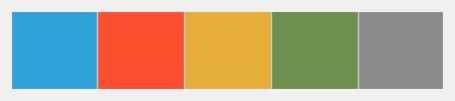

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)
sns.palplot(sns.color_palette())
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from scipy.stats import pearsonr

from itertools import product
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [12]:
segmentation_df = pd.read_csv('segmentation_data.csv')
print('There are {} rows and {} columns in our dataset.'.format(segmentation_df.shape[0],segmentation_df.shape[1]))

There are 2000 rows and 9 columns in our dataset.


In [13]:
segmentation_df.sample(10)

ID  Sex  Marital status  Age  Education  Income  Occupation  \
318   100000319    0               0   32          0   92257           1   
1331  100001332    1               1   58          2  139229           0   
1490  100001491    1               0   27          1  126268           1   
1965  100001966    0               0   24          0   44742           0   
972   100000973    1               1   29          1   41680           0   
831   100000832    1               1   23          1   97115           1   
717   100000718    0               0   32          0  129975           2   
1025  100001026    1               1   42          2  218664           2   
855   100000856    0               1   33          1  117039           1   
1330  100001331    1               1   50          2  147603           1   

      Settlement size  Spending score  
318                 2              37  
1331                1              57  
1490                1              29  
1965                0              12  
972                 0              25  
831                 2              32  
717                 2              34  
1025                2              58  
855                 2              42  
1330                0              46

In [14]:
segmentation_df.describe()

ID          Sex  Marital status          Age   Education  \
count  2.000000e+03  2000.000000     2000.000000  2000.000000  2000.00000   
mean   1.000010e+08     0.457000        0.496500    35.909000     1.03800   
std    5.774946e+02     0.498272        0.500113    11.719402     0.59978   
min    1.000000e+08     0.000000        0.000000    18.000000     0.00000   
25%    1.000005e+08     0.000000        0.000000    27.000000     1.00000   
50%    1.000010e+08     0.000000        0.000000    33.000000     1.00000   
75%    1.000015e+08     1.000000        1.000000    42.000000     1.00000   
max    1.000020e+08     1.000000        1.000000    76.000000     3.00000   

              Income   Occupation  Settlement size  Spending score  
count    2000.000000  2000.000000      2000.000000     2000.000000  
mean   120954.419000     0.810500         0.739000       35.317500  
std     38108.824679     0.638587         0.812533       12.544456  
min     35832.000000     0.000000         0.000000        7.000000  
25%     97663.250000     0.000000         0.000000       26.000000  
50%    115548.500000     1.000000         1.000000       34.000000  
75%    138072.250000     1.000000         1.000000       43.000000  
max    309364.000000     2.000000         2.000000       91.000000

By reviewing the data dictionary, we see that the dataset consists of information about the purchasing behavior of 2,000 individuals from a given area when entering a physical store. All data has been collected through the loyalty cards they use at checkout. The data has been preprocessed and there are no missing values. In addition, the volume of the dataset has been restricted and anonymized to protect the privacy of the customers.

There are 9 columns:

- `ID`-numerical-integer: Shows a unique identificator of a customer.
- `Sex`-categorical-{0,1}: Biological sex (gender) of a customer.
  - 0 Male
  - 1 Female
- `Marital Status`-categorical-{0,1}: Marital status of a customer.
   - 0 Single
   - 1 Non-Single (divorced / separated / married / widowed)
- `Age`-numerical-integer: The age of the customer in years.
   - Min value (the lowest age observed in the dataset)
   - Max value (the highest age observed in the dataset)
- `Education`-categorical-{0,1,2,3}: Level of education of the customer.
  - 0 Other / Unknown
  - 1 High School
  - 2 University
  - 3 Graduate School
- `Income`-numerical-real: Self-reported annual income in US dollars of the customer.
  - \$35,832 Min value (the lowest income observed in the dataset)
  - \$309,364 Max value (the highest income observed in the dataset)
- `Occupation`-categorical-{0,1,2}: Category of occupation of the customer.
  - 0 Unemployed/Unskilled
  - 1 Skilled Employee / Official
  - 2 Management / Self-Employed / Highly Qualified Employee / Officer
- `Settlement size`-categorical-{0,1,2}: The size of the city that the customer lives in.
  - 0 Small City
  - 1 Mid-Sized City
  - 2 Big City
- `Spending score`-numerical-integer: Numerical score between 0-100 for customer spending potential.
  - 0 (Low spending potential)
  - 100 (High spending potential)


Before we do any further analysis, we will perform the following two changes:
1.   As Settlement size refers to the size of cities, we will rename this variable to City size.
2.   The customer ID is not useful for further analysis. We will drop this column.

In [15]:
# Rename Settlement size to City size
segmentation_df = segmentation_df.rename(columns = {'Settlement size' : 'City size'})

# Drop the customer ID column
segmentation_df.drop('ID', axis=1, inplace=True)

Following the recommendations by [IBM](https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided), we won't one-hot encode the remaining categorical columns.

In [16]:
segmentation_df.isnull().sum()

Sex               0
Marital status    0
Age               0
Education         0
Income            0
Occupation        0
City size         0
Spending score    0
dtype: int64

As noted in the data dictionary, there is no missing data. Therefore, we won't perform data cleaning.

## Exploratory Data Analysis

#### Distributions
We will now analyze distributions of numerical variables in detail. For brevity, we will stratify `Age` and `Income` by the categorical variables `Sex` and `Marital Status`. We will start with `Sex` and create a variety of helper functions.

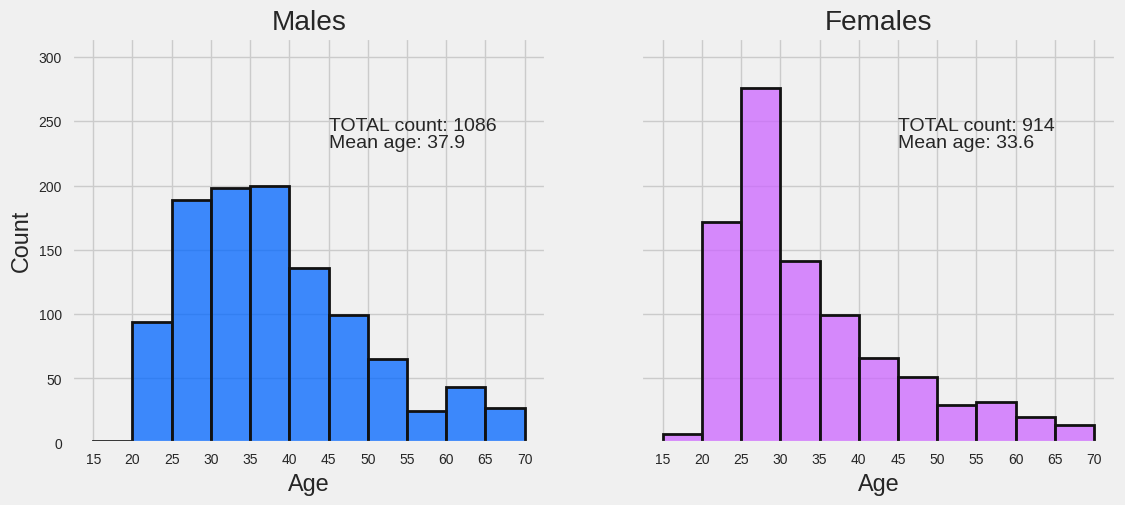

In [17]:
# Data subsets
males_age = segmentation_df[segmentation_df['Sex'] == 0]['Age']
females_age = segmentation_df[segmentation_df['Sex'] == 1]['Age']

# Age bins
age_bins = range(15, 75, 5)

plot_age_bins(males_age, females_age,'#0066ff','#cc66ff','Males', 'Females')

In [18]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.00


The average age of male customers is higher than female customers (37.9 against 33.6). Also, the distribution of male age is more uniform than females, where we can observe that the biggest age group is 25-30 years old. The Kolgomorov-Smirnov test shows that the differences between these two groups are statistically significant. There are also more male customers than female customers.


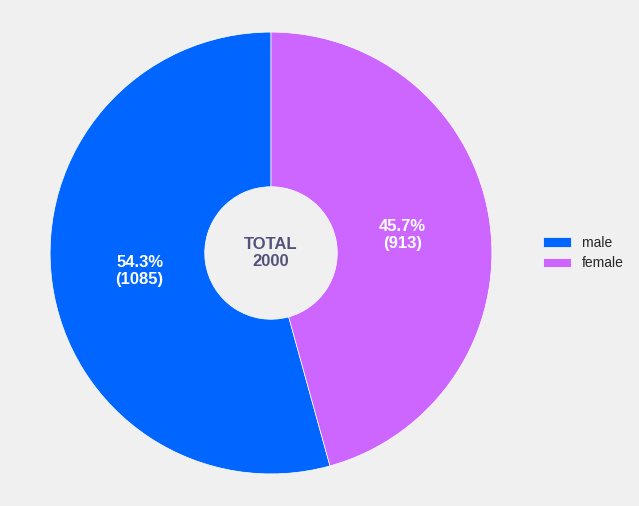

In [19]:
sizes = [males_age.count(),females_age.count()] # wedge sizes

make_pie_chart(sizes, '#0066ff','#cc66ff', (0.7, 0, 0.5, 1))

Males account for slightly more than 54% of the total customers.

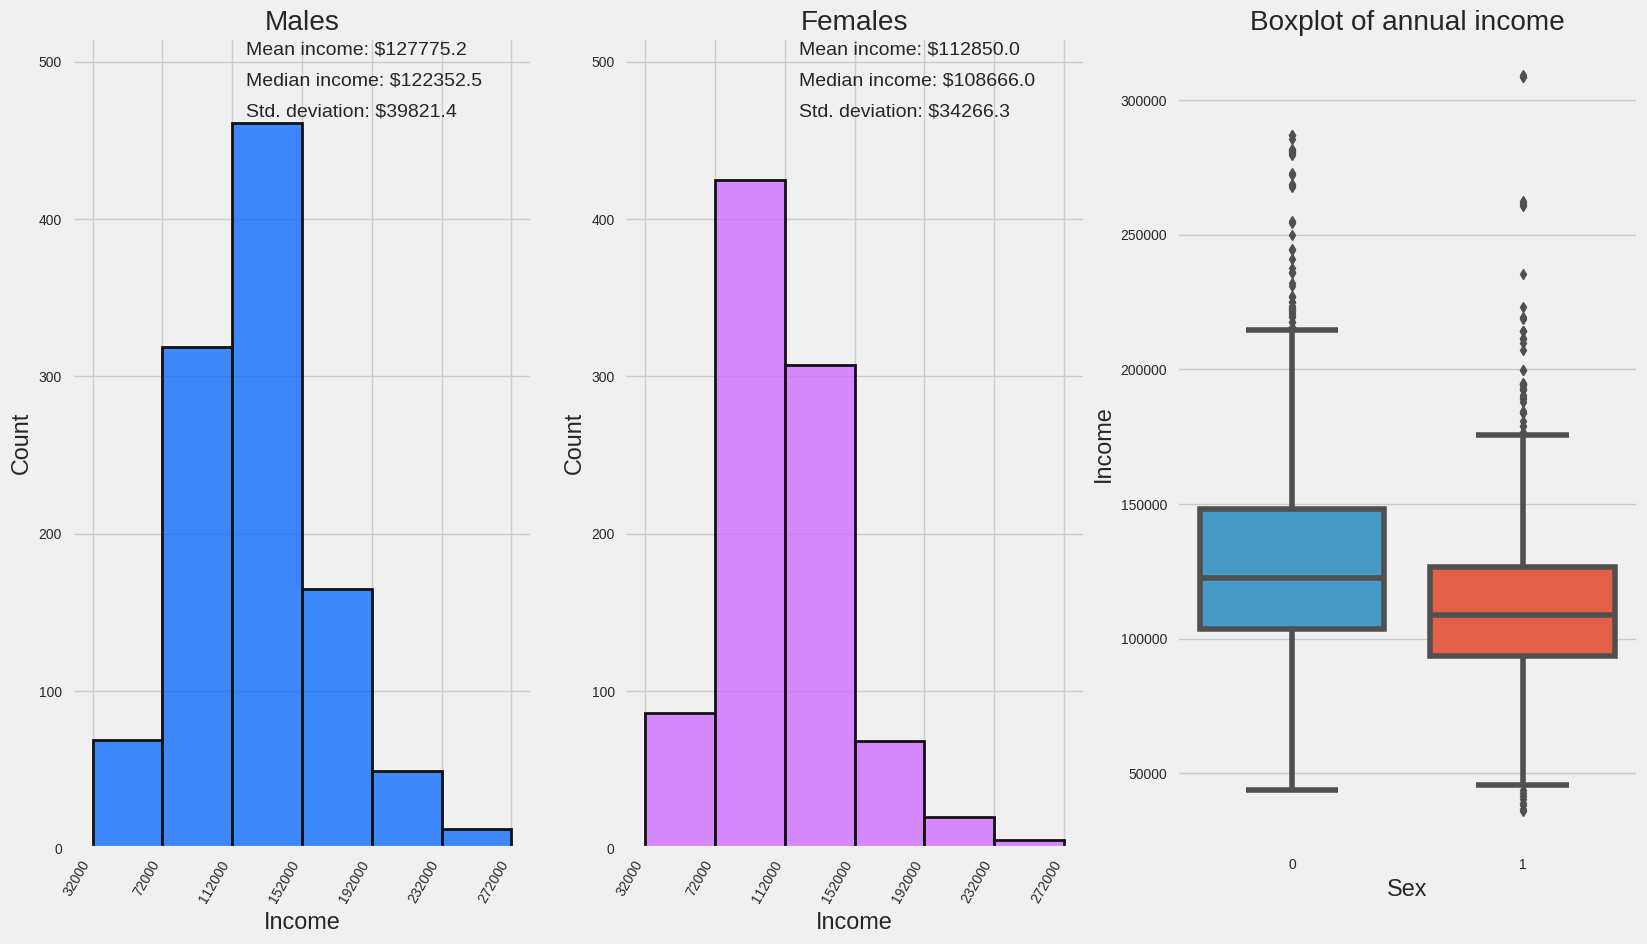

In [20]:
# Data subsets
males_income = segmentation_df[segmentation_df['Sex'] == 0]['Income']
females_income = segmentation_df[segmentation_df['Sex'] == 1]['Income']

plot_mean_income(males_income, females_income, '#0066ff', '#cc66ff', 'Males', 'Females', 'Sex')

In [21]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.00


The average income of males is higher than that of females (\$127,775 versus \$112,850). Both of groups have similar standard deviations. The Kolgomorov-Smirnov test shows that there is statistical differences between these two groups.

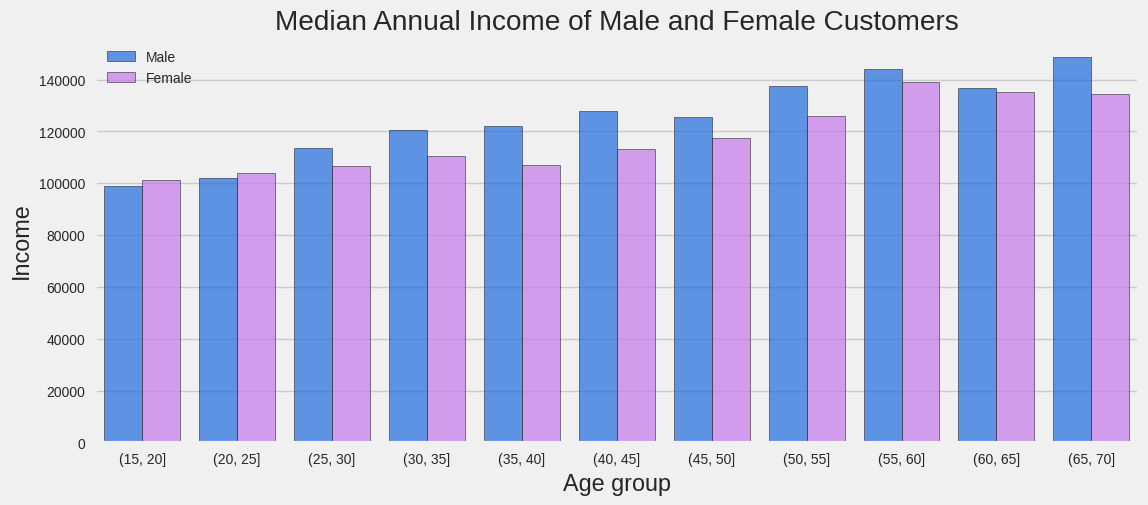

In [22]:
label_mapping = {0: 'Male', 1: 'Female'}
plt_title = 'Median Annual Income of Male and Female Customers'
plot_income_by_age_groups('Sex', age_bins, label_mapping, '#0066ff', '#cc66ff', plt_title)

This shows us that the most wealthy customers are in age range of 55-70 years old. The biggest difference between women and men is visible in age groups 65-70 (male more rich) and 15-20 (female more rich).


Next, we will analyze the categorical variable `Marital Status`.



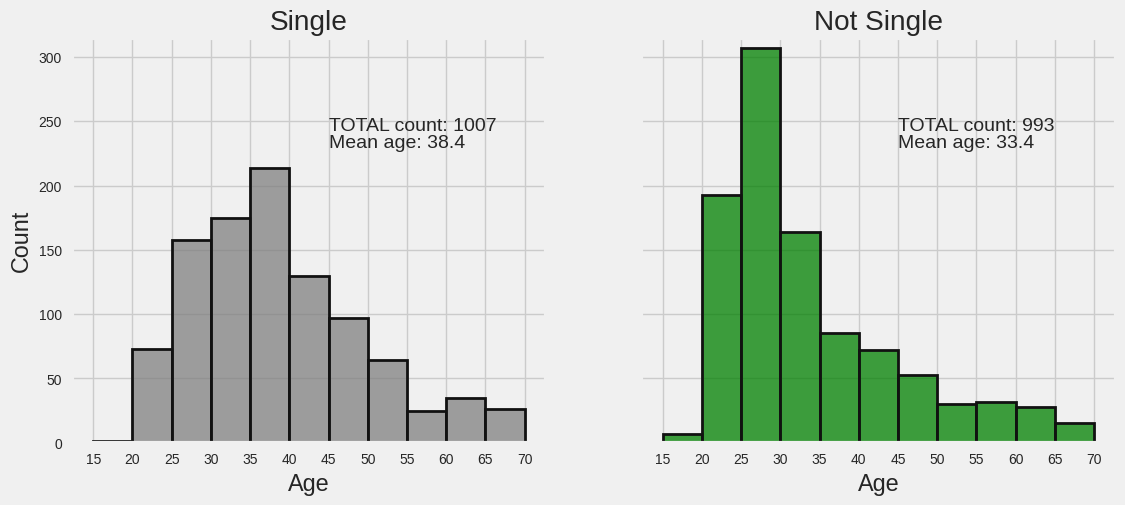

In [23]:
# Data subsets
single_age = segmentation_df[segmentation_df['Marital status'] == 0]['Age']
non_single_age = segmentation_df[segmentation_df['Marital status'] == 1]['Age']

plot_age_bins(single_age, non_single_age,'grey','green','Single', 'Not Single')

In [24]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(single_age, non_single_age)[1]))

Kolgomorov-Smirnov test p-value: 0.00


Surprisingly, the mean age of singles is higher than the mean age of non-singles (38.4 years versus 33.4 years). The Kolgomorov-Smirnov test shows that the differences between these two groups are statistically significant. There are also more singles than non-singles.

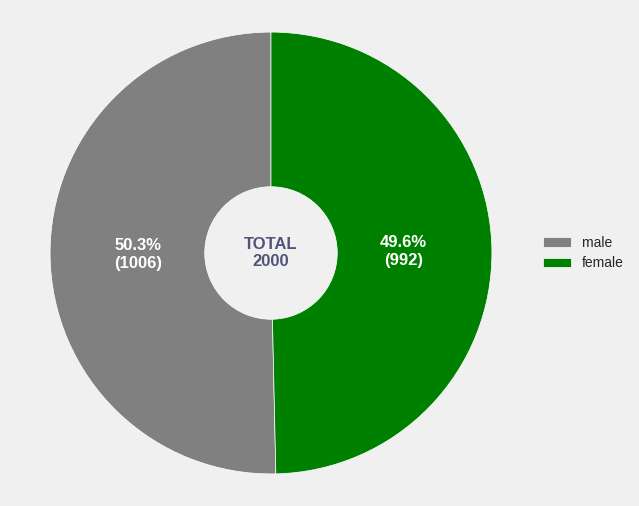

In [25]:
sizes = [single_age.count(),non_single_age.count()] # wedge sizes

make_pie_chart(sizes, 'grey','green', (0.8, 0, 0.5, 1))

Singles account for slightly more than 50% of the total customers.

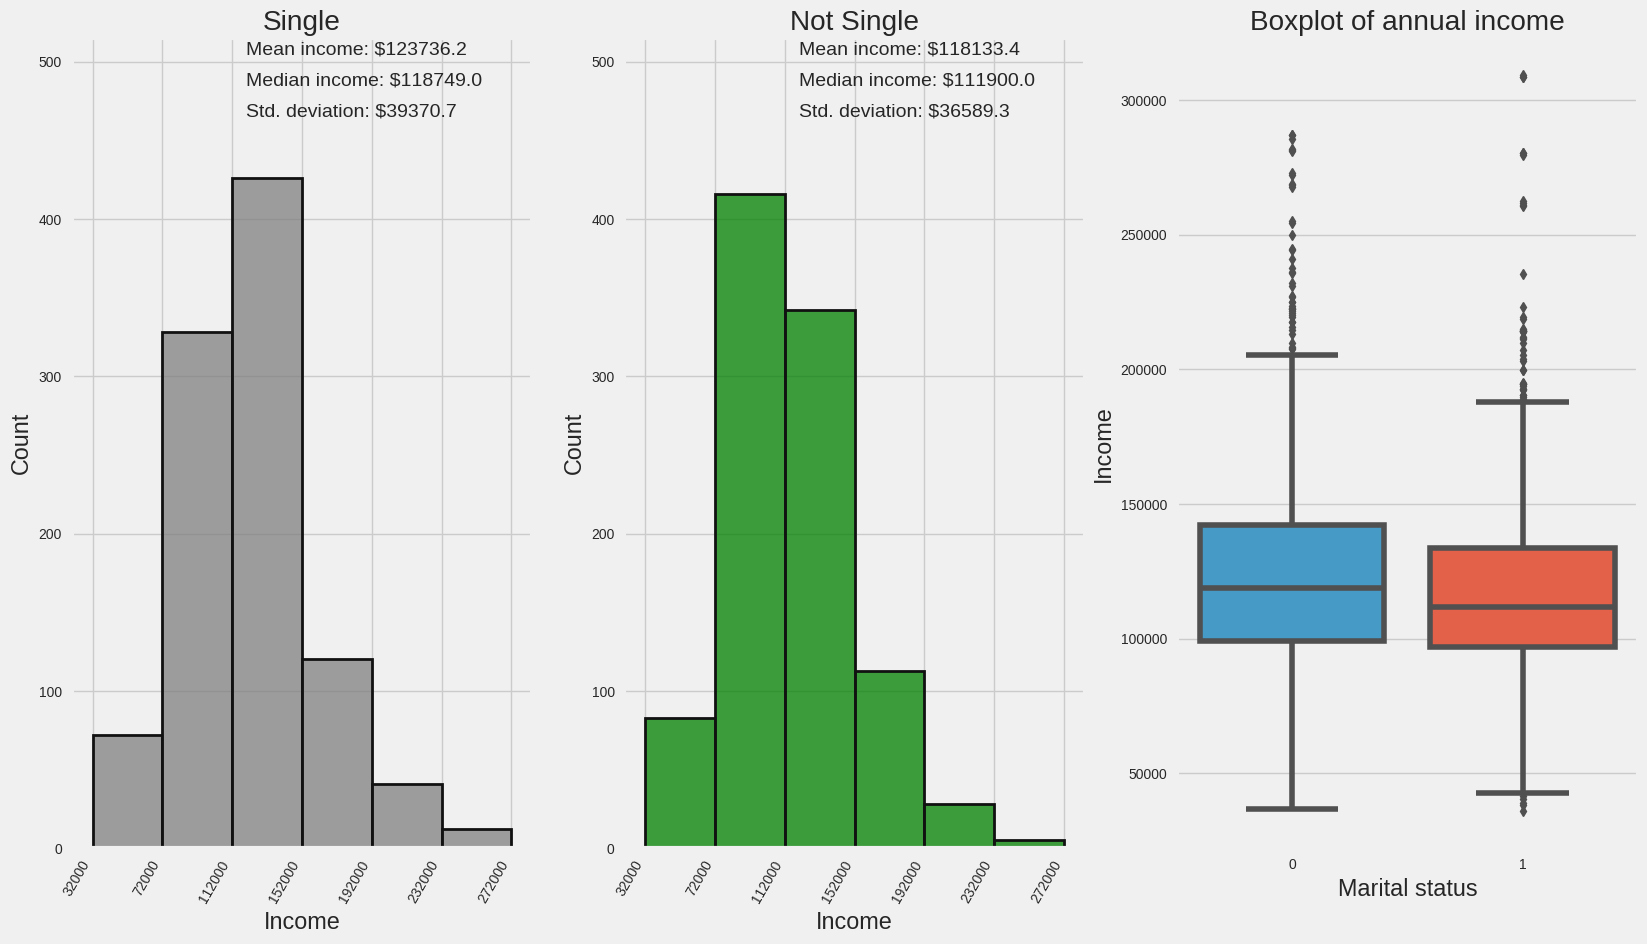

In [26]:
# Data subsets
single_income = segmentation_df[segmentation_df['Marital status'] == 0]['Income']
non_single_income = segmentation_df[segmentation_df['Marital status'] == 1]['Income']

plot_mean_income(single_income, non_single_income, 'grey', 'green', 'Single', 'Not Single', 'Marital status')

In [27]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(single_income, non_single_income)[1]))

Kolgomorov-Smirnov test p-value: 0.00


Suprisingly, the mean income of singles is higher than that of non-singles      (\$123,736 versus \$118,133). The K-S test shows that the difference between these two groups are statistically significant.

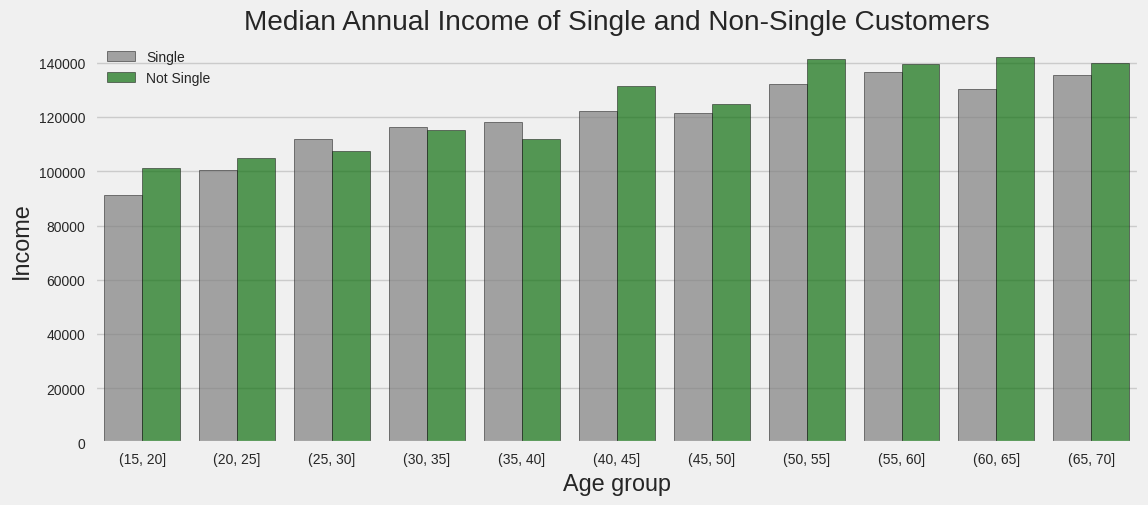

In [28]:
label_mapping = {0: 'Single', 1: 'Not Single'}
plt_title = 'Median Annual Income of Single and Non-Single Customers'
plot_income_by_age_groups('Marital status', age_bins, label_mapping, 'grey', 'green', plt_title)

As before, the most wealthy customers are in age range of 55-70 years old. The biggest difference between single and non-single is visible in age groups 35-40 (single more rich) and 15-20 (not single more rich).

#### Correlations

We will now investigate correlations between numerical variables.

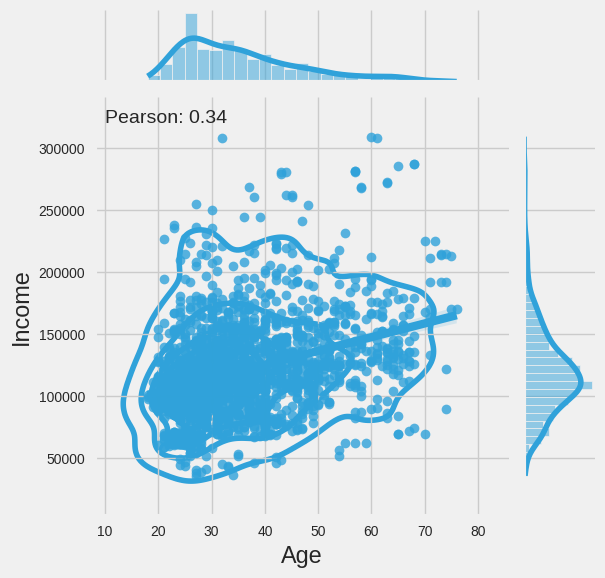

In [29]:
# calculating Pearson's correlation
corr, _ = pearsonr(segmentation_df['Age'], segmentation_df['Income'])

jp = (sns.jointplot(data=segmentation_df, x='Age', y='Income',
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(10,320000, 'Pearson: {:.2f}'.format(corr))
plt.show()

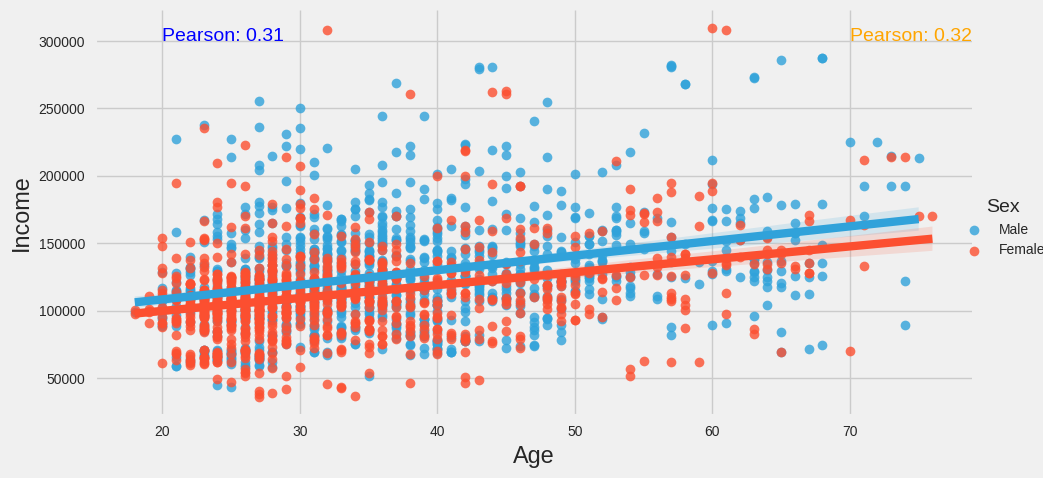

In [30]:
# Calculate Pearson Correlation between Age and Income
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)
visual_corr(segmentation_df, corr1, corr2, 'Age', 'Income', 'Sex', 'Male', 'Female')

There is a slight correlation between age and annual income for male and female customers.

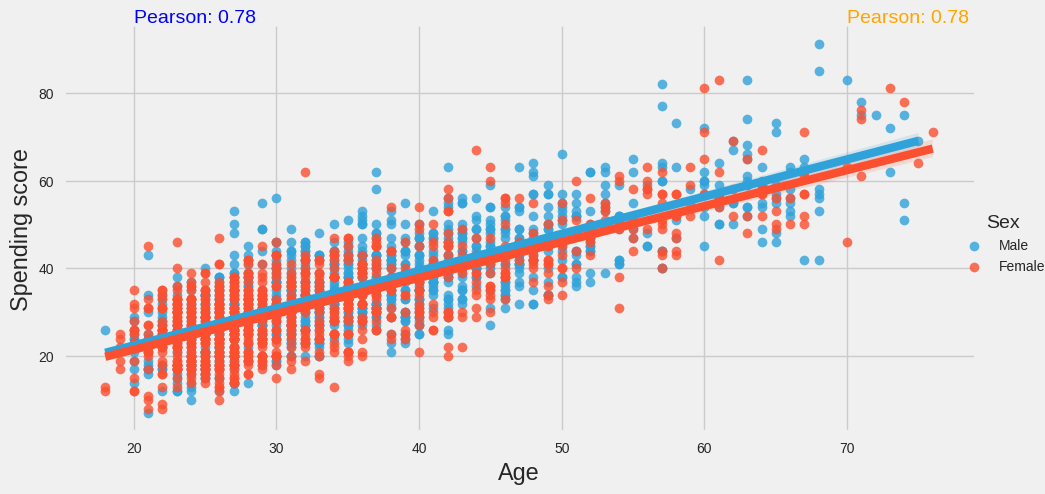

In [31]:
# Calculate Pearson Correlation between Age and Spending Score
males_spending = segmentation_df[segmentation_df['Sex']==0]['Spending score']
females_spending = segmentation_df[segmentation_df['Sex']==1]['Spending score']
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)
visual_corr(segmentation_df, corr1, corr2, 'Age', 'Spending score', 'Sex', 'Male', 'Female')

There is also a stronger correlation between age and spending score for male and female customers.

We will also construct a heatmap to visualize correlations between all variables.

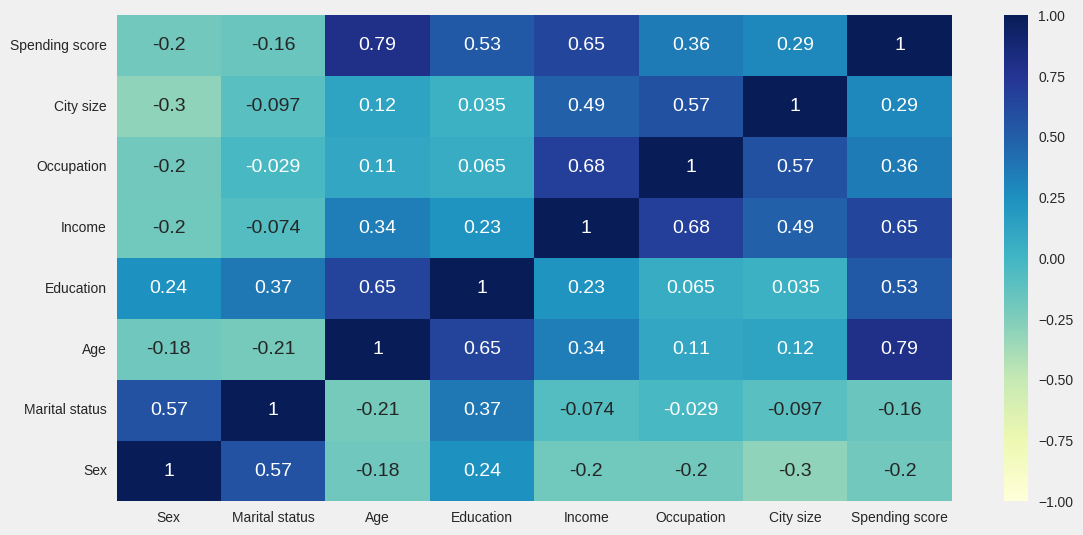

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
# segmentation_df_copy = segmentation_df.copy()
# corr_df = segmentation_df_copy.drop(columns=['Spending score'])
sns.heatmap(segmentation_df.corr(), vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

## Data Visualization

For the remaining categorical columns, we will visualize data to become more familiar with the data. For brevity, we will restrict our analysis to comparison with income.

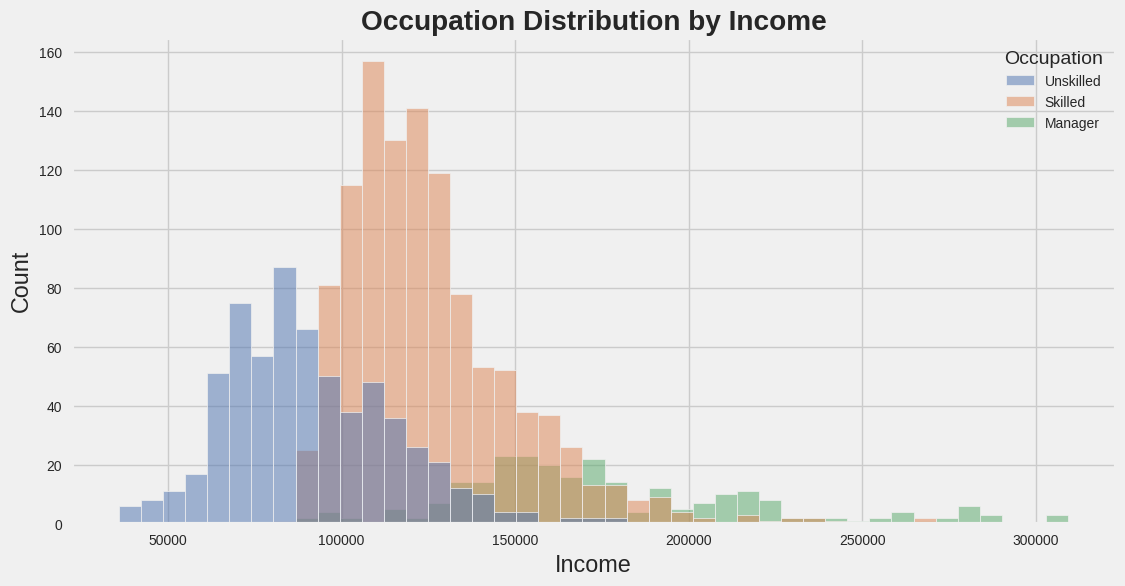

In [33]:
# Distribution of Income by Occupation
plt_title = 'Occupation Distribution by Income'
leg_entries = ['Unskilled', 'Skilled', 'Manager']
plot_distribution_by_income('Occupation', plt_title, leg_entries)

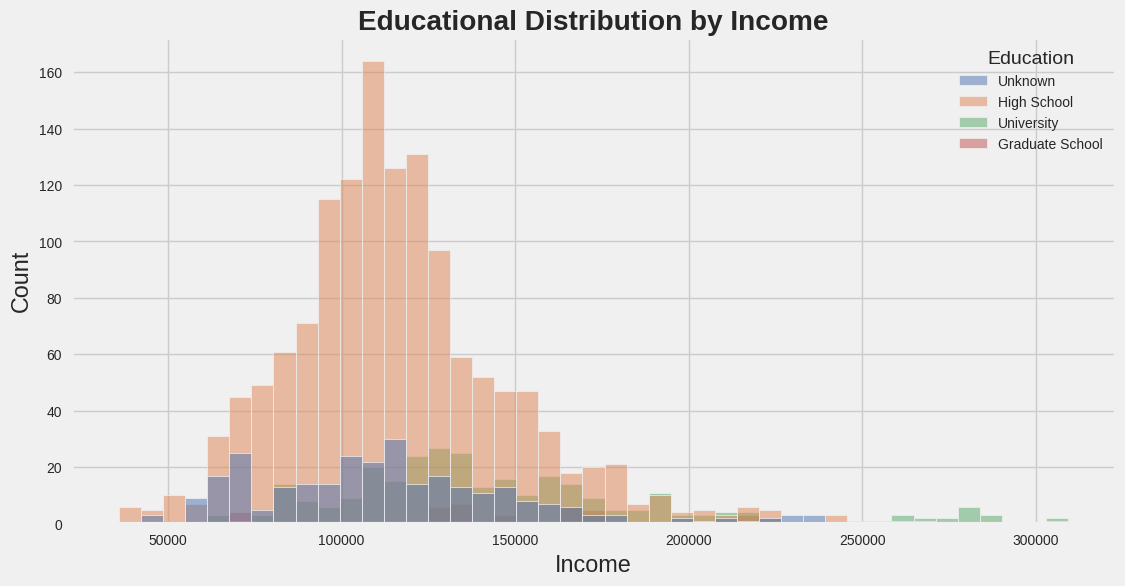

In [34]:
# Distribution of Income by Educational Achievement
plt_title = 'Educational Distribution by Income'
leg_entries = ['Unknown', 'High School', 'University', 'Graduate School']
plot_distribution_by_income('Education', plt_title, leg_entries)

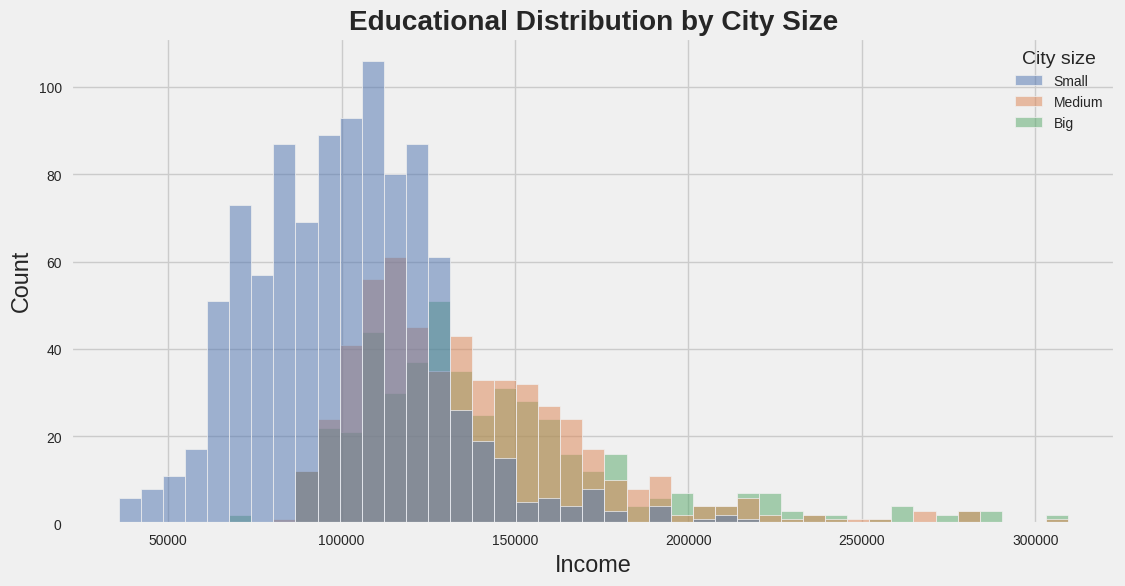

In [35]:
# Distribution of Income by City Size
plt_title = 'Educational Distribution by City Size'
leg_entries = ['Small', 'Medium', 'Big']
plot_distribution_by_income('City size', plt_title, leg_entries)

These results match out intuition - highly skilled workers recieve higher pay and those in large cities have a higher annual income than those in small cities. Let's also visualize the numerical variables against the categorical variables.

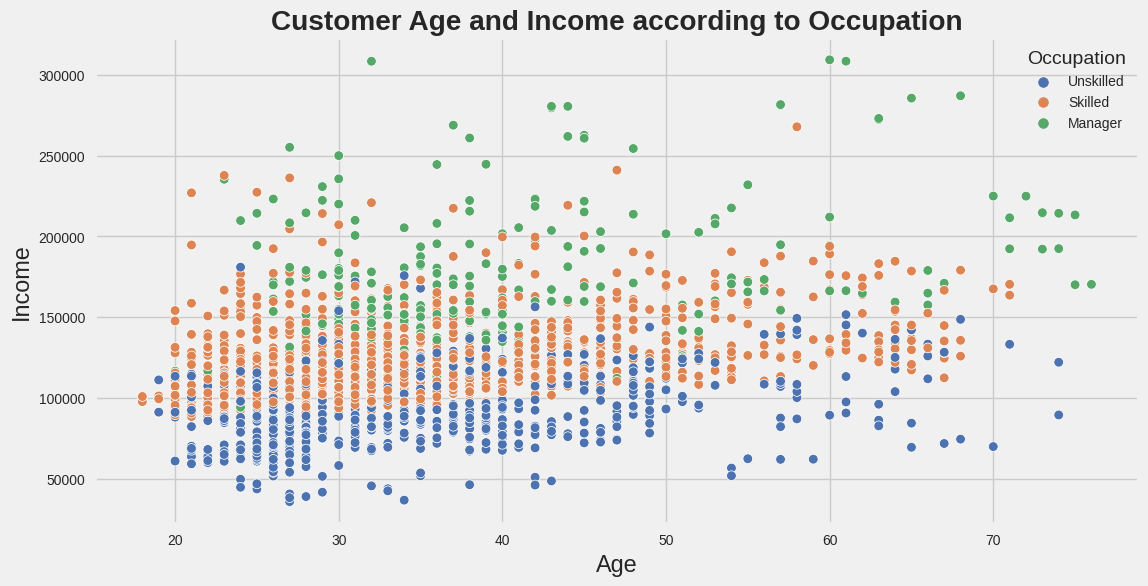

In [36]:
plt_title = 'Customer Age and Income according to Occupation'
leg_entries = ['Unskilled', 'Skilled', 'Manager']
plot_age_vs_income_scatter('Occupation', plt_title, leg_entries)

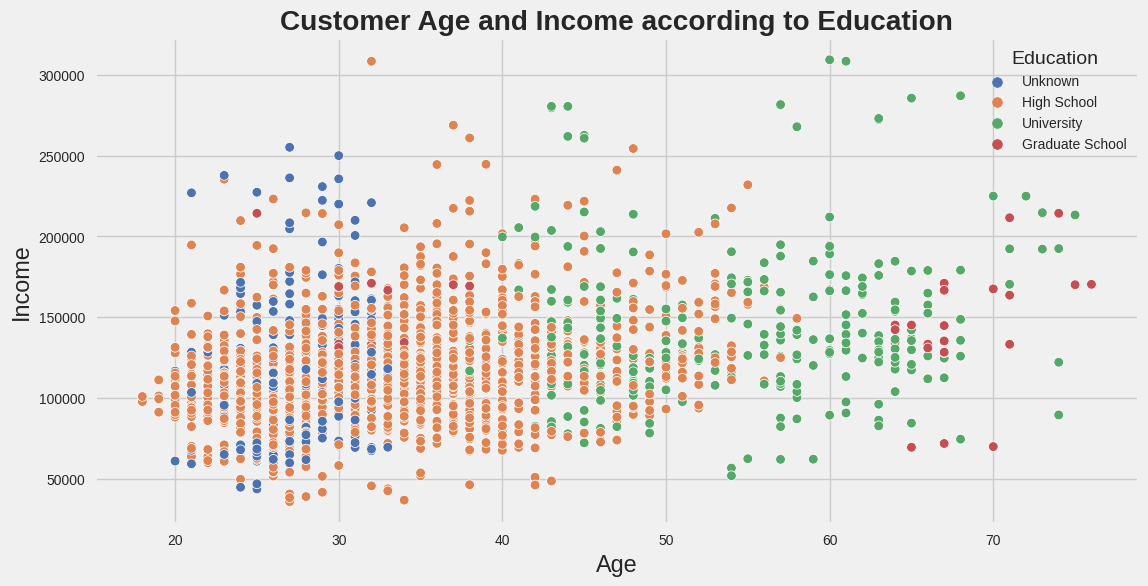

In [37]:
plt_title = 'Customer Age and Income according to Education'
leg_entries = ['Unknown', 'High School', 'University', 'Graduate School']
plot_age_vs_income_scatter('Education', plt_title, leg_entries)

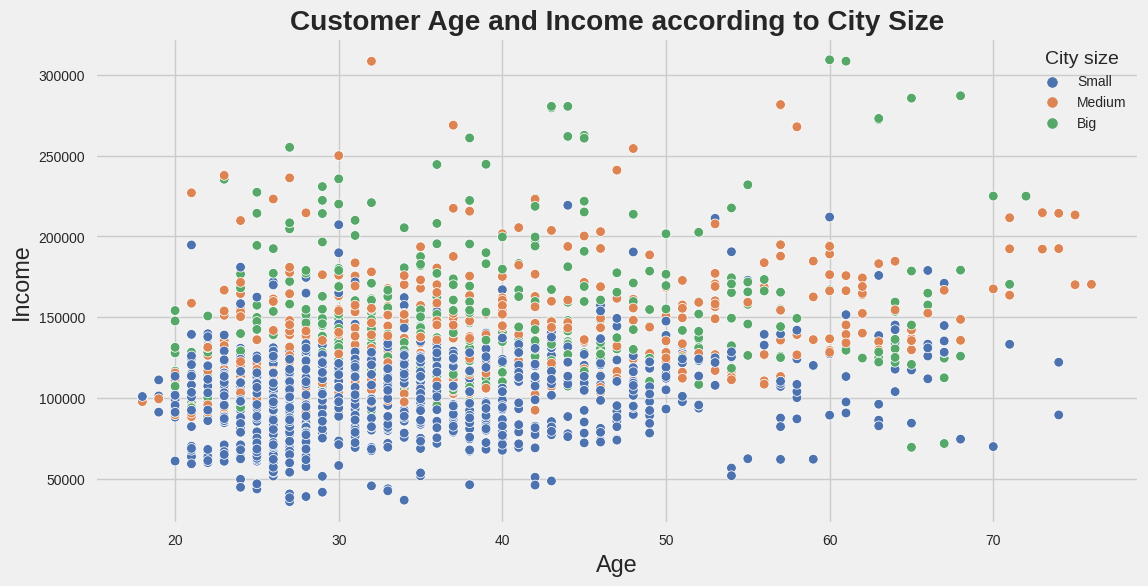

In [38]:
plt_title = 'Customer Age and Income according to City Size'
leg_entries = ['Small', 'Medium', 'Big']
plot_age_vs_income_scatter('City size', plt_title, leg_entries)

## Model Preparation

We will now subset our dataset and take out the numerical features which are the most significant. These include `Age`, `Income`, and `Spending score`.

In [39]:
X_num= segmentation_df[['Age','Income','Spending score']] # Continuous columns

## Clustering

We now describe and analyze three different clustering algorithms:

- K-Means
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Gaussian mixture models (GMM)


### K-Means
For clustering only numeric columns are used. Therefore, we will not include the categorical variables.

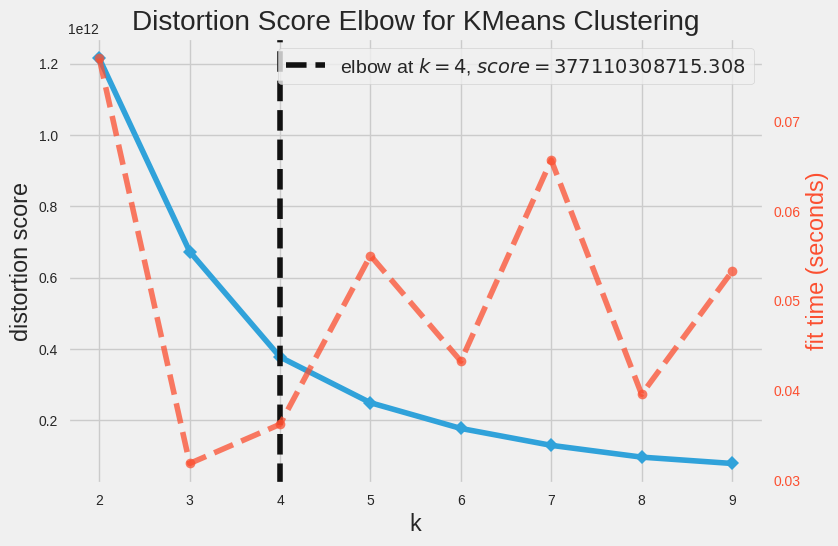

In [40]:
model = KMeans(n_init=10, random_state=123)
visualizer = KElbowVisualizer(model, n_init=10, k=(2,10))

visualizer.fit(X_num)
visualizer.show()
plt.show()


The graph above shows the reduction of a distortion score as the number of clusters increases. The underlying algorithm suggests 4 clusters. Another way to choose the best number of clusters is to plot the silhuette score in a function of number of clusters. Let's see the results.


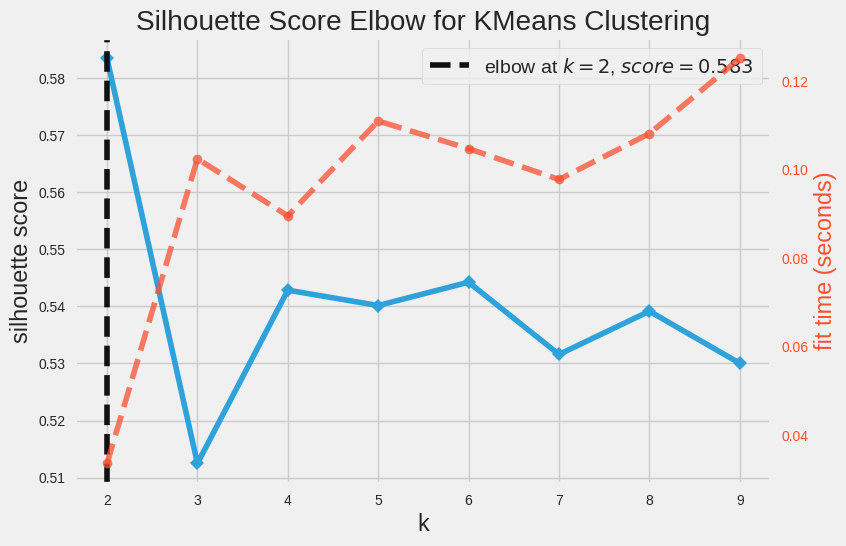

In [41]:
model = KMeans(n_init=10, random_state=123)
visualizer = KElbowVisualizer(model, k=(2,10), n_init=10, metric='silhouette')

visualizer.fit(X_num)
visualizer.show()
plt.show()

This time the silhouette score suggests 2 clusters. We will try 2 and 4 clusters.

##### 2 Clusters

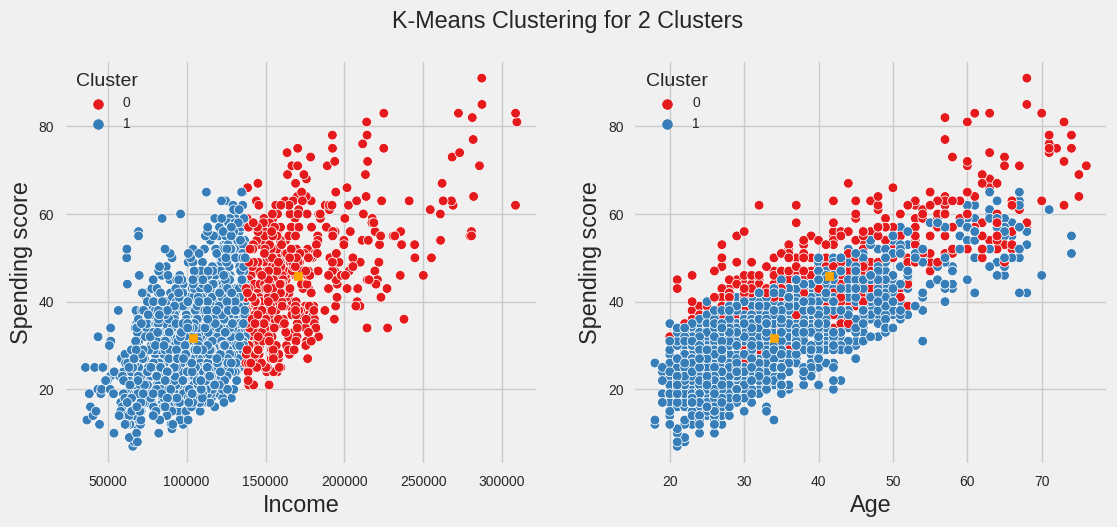

In [42]:
# Visualize 2 clusters
KM_clustered = visualize_knn_clusters(2, X_num)


The K-Means algorithm generated the following clusters:

- 1 group where consumers have a **low-medium** annual income and **low-medium** spending score
- 1 groups where consumers have a **high** annual income and **high** spending score
- 2 groups where a **higher age** generally increases the spending score



In [43]:
# Cluster size
KM_clust_sizes = KM_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["Size"]
KM_clust_sizes

Size
Cluster      
0         511
1        1489

Suprisingly, the larger cluster is number 1 with 1489 clients (which mostly consist of members with a lower spending score). Only 511 clients are in cluster 1. We can check the quality of both clusters through a Silhuette plot.

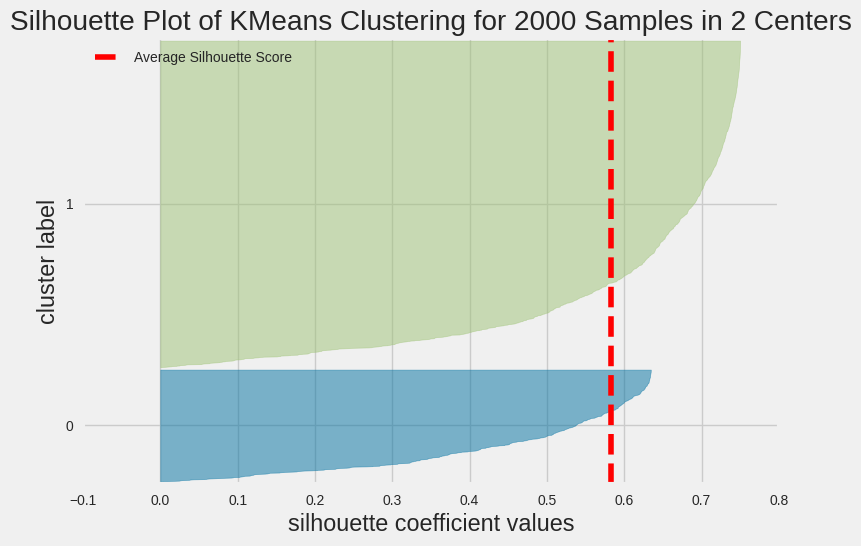

In [44]:
model = KMeans(n_clusters=2, n_init= 10, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_num)
visualizer.show()
plt.rcParams["figure.figsize"] = (12, 5)
plt.show()

##### 4 Clusters

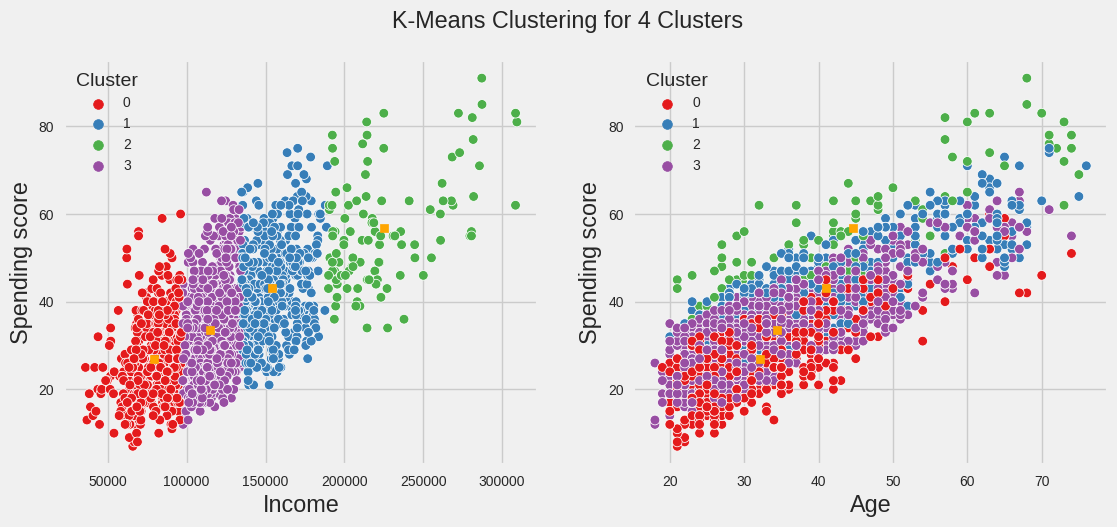

In [45]:
# Visualize 4 clusters
KM_clustered = visualize_knn_clusters(4, X_num)

The K-Means algorithm generated the following clusters:

- 1 group where consumers have a **low** annual income and **low** spending score
- 2 groups where consumers have a  **medium** annual income and **medium** spending score
- 1 group where consumers have a **high** annual income and **high** spending score
- 4 groups where a **higher age** generally **increases** the spending score


In [46]:
# Cluster size
KM_clust_sizes = KM_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["Size"]
KM_clust_sizes

Size
Cluster      
0         486
1         455
2         105
3         954

The two largest clusters  are number 0 and 1 with 486 and 455 clients (with small or medium annual income clients). The higher income clients correspond to clusters 2 and 3. To check the quality of each cluster we construct a Silhuette plot.


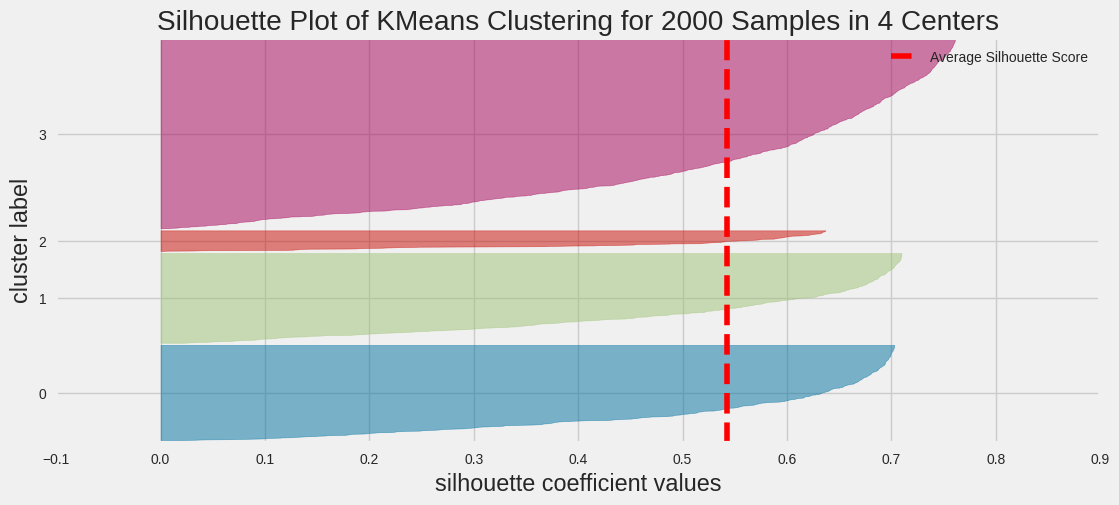

In [47]:
model = KMeans(n_clusters=4, n_init= 10, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_num)
visualizer.show()
plt.rcParams["figure.figsize"] = (12, 5)
plt.show()

### DBSCAN

In DBSCAN there are two primary hyperparameters:

- `eps`
- `min_samples`

We will investigate which combinations work best.


In [48]:
eps_values = np.arange(2,16,0.5) # eps values to be investigated
min_samples = np.arange(2,10) # min_samples to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

Because DBSCAN creates clusters itself based on these two parameters let's check the number of generated clusters and create a heatmap to visualize the optimal parameters.


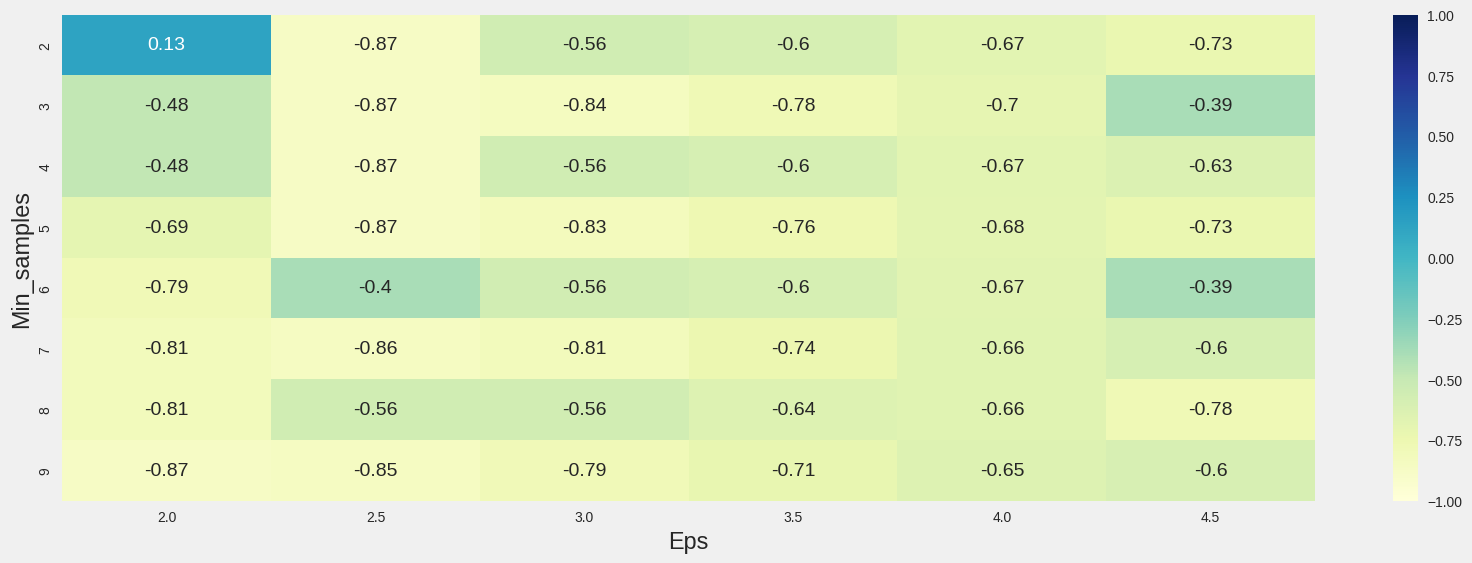

In [49]:
# Create heatmap to find optimal eps and min_samples
DBSCAN_heatmap_eps_min_samples(X_num)

The maximum is at `eps=2` and `min_samples=2`. Next, we will review cluster sizes.

In [50]:
# Find cluster sizes
DBS_clustering = DBSCAN(eps=2, min_samples=2).fit(X_num)
DBSCAN_clust_sizes, DBSCAN_clustered = DBSCAN_cluster_size(X_num, DBS_clustering)
DBSCAN_clust_sizes

Size
Cluster      
-1       1998
 0          2

DBScan found 2 clusters. Let's plot them.

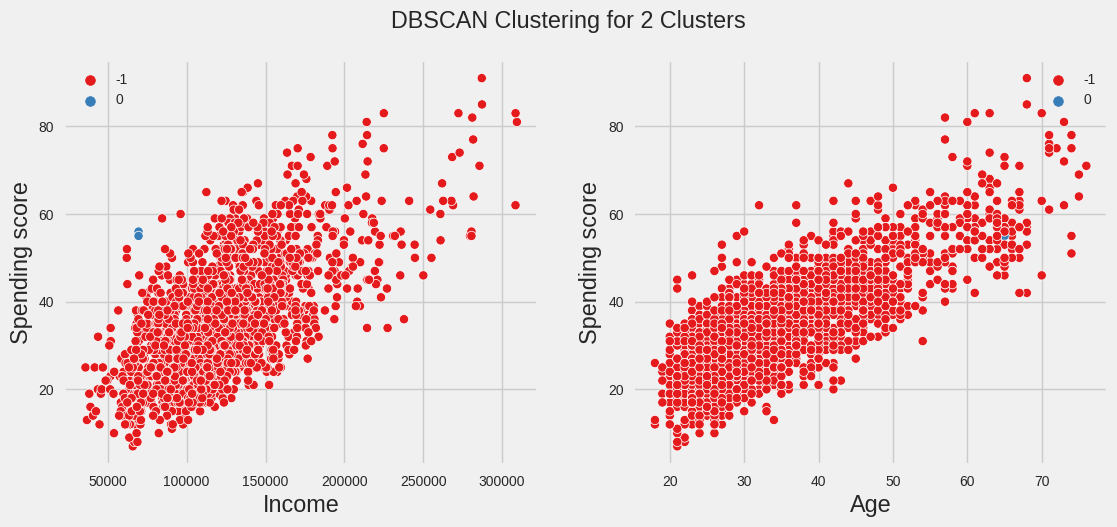

In [51]:
plot_DBSCAN_clusters(X_num)

DBSCAN did not perform well in cluster analysis of our dataset.

### GMM

As a final clustering tchnique, we look at Gaussian mixture models (GMM). As with K-means, let's find the optimal number of clusters.

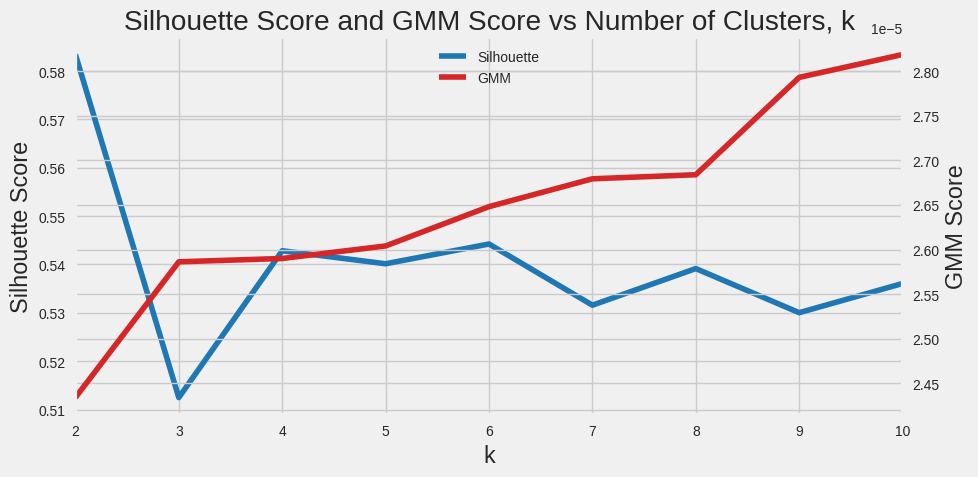

In [70]:
visualize_silhouette_score_gmm(X_num)

Four clusters should work. Let's visualize our results.

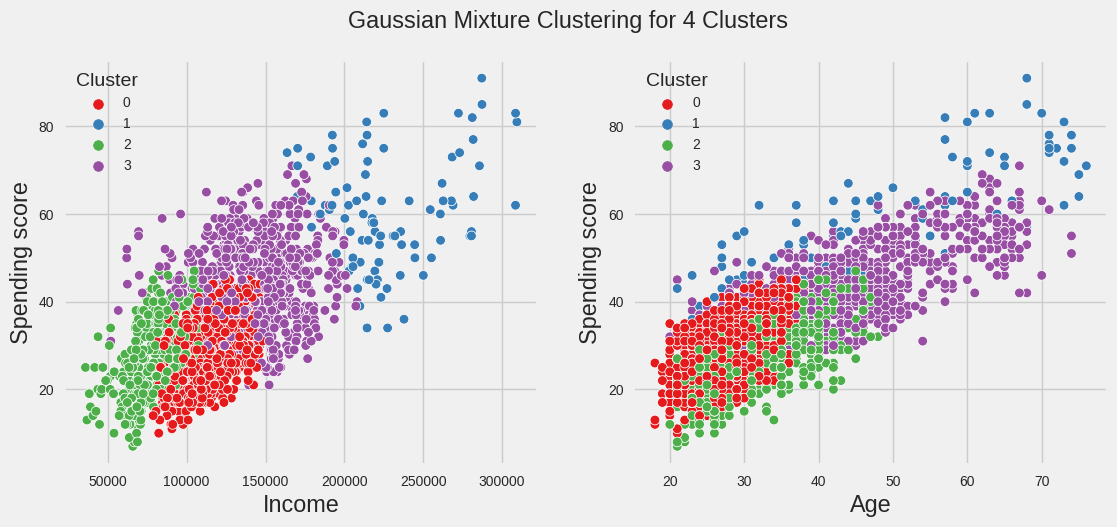

In [53]:
GM_clusters, GM_clustered = visualize_gmm_clusters(4, X_num)

As with K-means, we see a similar pattern in cluster groups with GMM:

- 2 groups where consumers have a **low** annual income and **low** spending score
- 1 group where consumers have a  **medium** annual income and **medium** spending score
- 1 group where consumers have a **high** annual income and **high** spending score
- 4 groups where a **higher age** generally **increases** the spending score


In [54]:
# Cluster size
GM_clust_sizes = GM_clustered.groupby('Cluster').size().to_frame()
GM_clust_sizes.columns = ["Size"]
GM_clust_sizes

Size
Cluster      
0         878
1          92
2         374
3         656

Now the largest cluster is number 0 with 878 clients (small or medium annual income clients). The higher income clients correspond to clusters 2 and 3. As with K-Means, we get a resonable Silhuette score for our 4 clusters.

In [55]:
print("The silhouette score of the GMM solution: {}"
      .format(silhouette_score(X_num, GM_clusters, metric='euclidean')))

The silhouette score of the GMM solution: 0.21313808999468153


## Dimensionality Reduction

We will also visualize our four clusters through Agglomerative clustering. We will use PCA to see clear distinctions between our four clusters.

### PCA

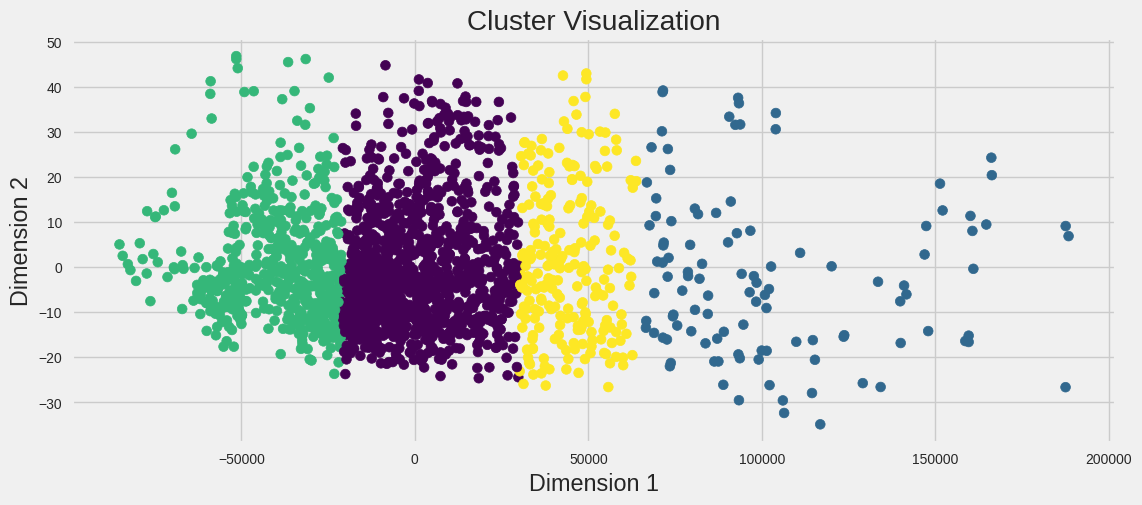

In [56]:
# Visualize four clusters through PCA
y_pred, pca_components = visualize_pca(X_num)

In [57]:
# Visualize the four clusters in three dimensions
visualize_pca_3d(y_pred, pca_components)

The three dimensional visualization through Plotly shows that our clusters are well sperated from each other and classify clients according to age, income, and spending score.

## Cluster Comparison and Analysis
In this project we analyzed mall customer data through three clustering techniques: K-Means, DBSCAN, and GMM. We found that K-Means and GMM returned reasonable results for our test set.

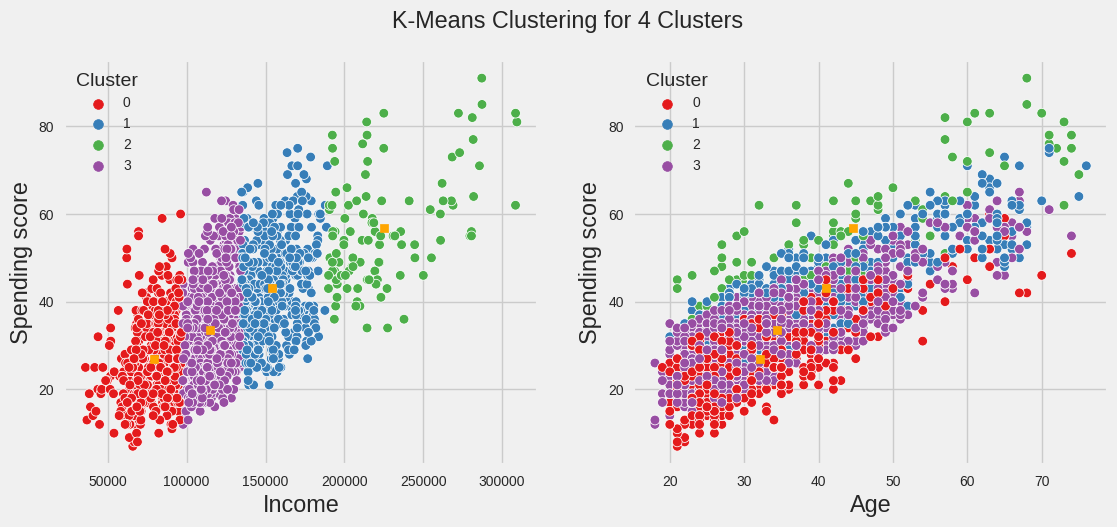

In [58]:
# Visualize 4 clusters through K-Means
KM_clustered = visualize_knn_clusters(4, X_num)

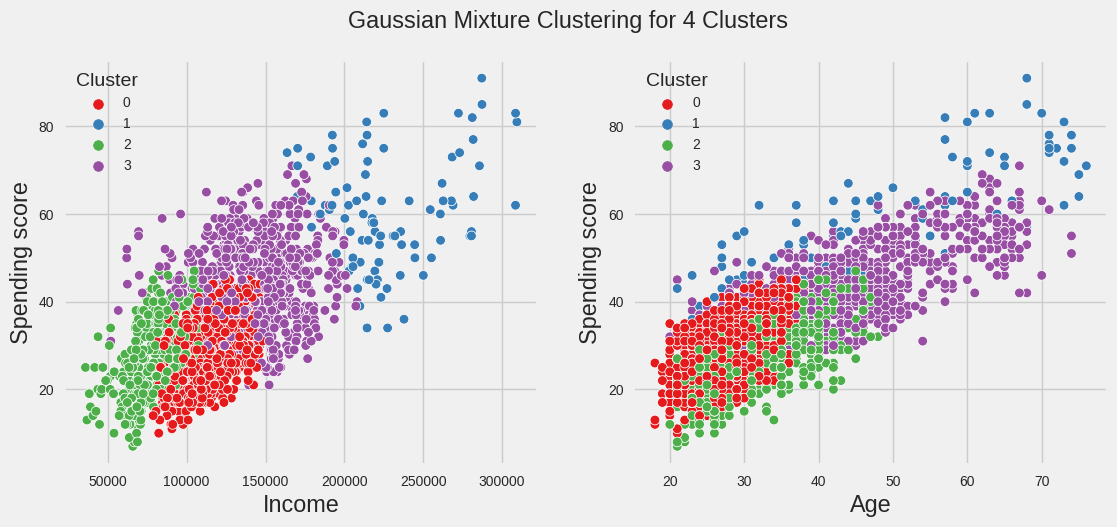

In [59]:
# Visualize 4 clusters through GMM
GM_clustered = visualize_gmm_clusters(4, X_num)

We can combine all three of our clustering methods in a table to visualize the number of clients in every cluster.

In [60]:
all_clusters = pd.concat([KM_clust_sizes, DBSCAN_clust_sizes, GM_clust_sizes],axis=1, sort=False)
all_clusters

Size    Size   Size
Cluster                      
 0       486.0     2.0  878.0
 1       455.0     NaN   92.0
 2       105.0     NaN  374.0
 3       954.0     NaN  656.0
-1         NaN  1998.0    NaN

It is evident from the preceding table that DBSCAN was unable to produce clusters that made sense. The most plausible explanation for this is that DBCSAN looks for clusters based on point density. DBSCAN will not identify the least dense group as a cluster if one of our clusters is less dense than the others, leading to less than ideal results.

In turn, K-Means and Gaussian Mixture Model created 4 reasonable clusters highlighting:

- Clients with a **low** income had a **lower** spending score
- Clients with a **high** income have a **higher** spending score
- **Older** clients generally have a higher spending score




## Discussion and Recommendations

Conclusions from our analysis:
* In this project, we used consumer data from 2,000 individuals at a shopping mall to categorize customers based on income, age, and spending score. We also had access to categorical data such as gender, marital status, education, and city size which we used to compare and classify against annual income.
* As expected, we observed that skilled and highly educated individuals made a higher annual income than those that are less skilled. Individuals who live in big cities generally have a larger annunal income than those who live in smaller cities. Through data visualization, we found that males made more money than females and singles made more money than those that were not single.
* Through cluster analysis we found that those with a higher age and income had a higher spending score. Therefore, wealthier customers (including highly educated ones) have a higher spending potential at a shopping mall.

Recommendations for further research:
* We could further analyze our categorical variables: city size, education, gender, marital status, and occupation to see if they have a significant impact on customer groups.
* Outside of looking at age, income, and spending score, we could analyze other factors which influence customer spending in shopping malls. According to [this study](https://www.researchgate.net/publication/319249112_Factors_Influencing_Selection_of_Shopping_Malls_An_Exploratory_Study_of_Consumer_Perception), mall architecture, security, music, and available parking all have significant impact on consumers.
* We could also segment customers based on their activities in the mall. According to [this study](https://chaireomerdesserres.hec.ca/wp-content/uploads/2020/05/Another-trip-to-the-mall.pdf), mall atmosphere (odors, music and decorations), density (number of shoppers), and store preferences also have a large impact on consumer spending.
